# Combined File

This file should combine all the other experiments

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.colors import to_rgb
from matplotlib.colors import LinearSegmentedColormap

# Model and Training Params

In [26]:
# Model Params
num_hidden = 6 # number of hidden layers. The total network has additionl 2 layers: input to hidden and hidden to output
input_dim = 2
hidden_dim = 2
output_dim = 1
activation = 'tanh' #'relu' and 'tanh' are supported

# Training Params
load_file = None
cross_entropy = True #True supported with binary classification only
num_epochs = 500

288


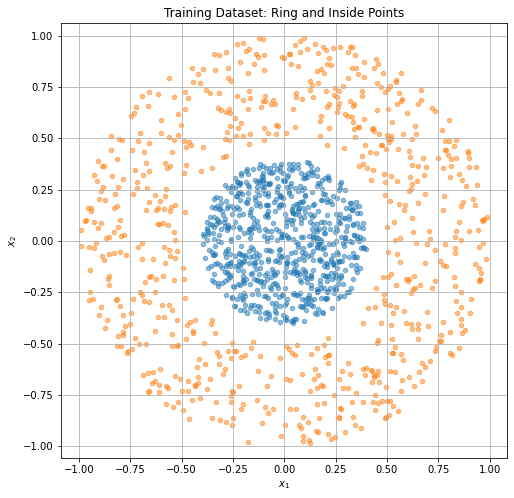

In [27]:
import models.training
from models.training import make_circles_uniform

# Generate training data

# Set random seed for reproducibility
seed = np.random.randint(1000)
# seed = 163
np.random.seed(seed)
torch.manual_seed(seed)

#footnnote to display on plots to make sure that plots and model/trainign params do not get confused
footnote = f'num_hidden={num_hidden}, input_dim={input_dim}, hidden_dim={hidden_dim}, output_dim={output_dim}, act={activation}, seed={seed}, ce={cross_entropy}'

n_points = 2000 #number of points in the dataset

inner_radius = 0.5
outer_radius = 1
buffer = 0.2

import importlib
importlib.reload(models.training) # Reload the module

train_loader, test_loader = make_circles_uniform(output_dim = 1, n_samples = n_points, inner_radius = 0.5, outer_radius = 1.0, buffer = 0.1, cross_entropy=cross_entropy, seed = seed)

In [28]:
for input, label in train_loader:
    print(input[:5], label[:5])
    break

tensor([[-0.2014,  0.6887],
        [-0.5626, -0.3118],
        [ 0.2864,  0.7565],
        [ 0.2464, -0.9547],
        [ 0.5189,  0.3189]]) tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])


# Define model and training


In [29]:
class ResidualBlock(nn.Module):
    """
    Residual Block that includes a batch normalization layer and a skip connection with adjustable skip parameter. 
    skip_param = 0 means no skip connection, skip_param = 1 means standard skip connection.
    The activation function can be set to 'relu', 'tanh', or 'id' (identity).
    """ 
    
    def __init__(self, features, skip_param = 1, activation = 'relu', batchnorm = True):

        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(features, features)
        if batchnorm: #batchnorm is important to stabilize the training for deeper networks
            self.bn = nn.BatchNorm1d(features)
            
        if activation == 'relu':
            self.activation = nn.ReLU()
        if activation == 'tanh':
            self.activation = nn.Tanh()
        if activation == 'id':
            self.activation = nn.Identity()
        self.skip_param = skip_param
    def forward(self, x):
        identity = x #cont here
        out = self.fc(x)
        if hasattr(self, 'bn'):
            out = self.bn(out)
        out = self.activation(out)
        out = out + self.skip_param * identity
        return out

class ResNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden, skip_param = 1, activation = 'relu'):
        
        super(ResNet, self).__init__()
        self.num_hidden = num_hidden
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        if activation == 'relu':
            self.activation = nn.ReLU()
        if activation == 'tanh':
            self.activation = nn.Tanh()
        if activation == 'id':
            self.activation = nn.Identity()
            
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim, skip_param=skip_param, activation = activation) for _ in range(num_hidden)]
        )
        self.output_fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, output_layer = True):
        x = self.activation(self.input_fc(x))
        x = self.res_blocks(x)
        if output_layer:
            x = self.output_fc(x)
            x = torch.sigmoid(x)
        return x
    
    '''
    sub_model is used to access a partial network of the input to output network
    layers are counted from 0 (input to hidden dim) until nth layer ( (n-1)th hidden layer to output layer)
    from_layer is the starting layer that is included in the sub_model
    to_layer is the final layer included in the sub_model
    e.g. from_layer = 1, to_layer = 2 includes the first two ResBlocks
    initial layer is counted as layer 0
    hidden to output layer is counted as final layer
    '''
    def sub_model(self, x, from_layer, to_layer):
        if to_layer > self.num_hidden + 1:
            print('Error: to_layer is larger than existing number of layers')
            return
        if from_layer > to_layer:
            print('Error: to_layer cannot be larger than from_layer')
        
        
        if from_layer == 0:
            x = self.activation(self.input_fc(x))
            from_layer += 1 #if from_layer = 0 I need to increase the from_layer count

        if to_layer > 0 and from_layer < self.num_hidden + 1:
            reduced_block = self.res_blocks[from_layer - 1 : to_layer] #from layer 1 to 2 means hidden layer 0 to hidden layer 1
            x = reduced_block(x)
        if to_layer == self.num_hidden + 1:
            x = self.output_fc(x)
        return x
            


In [84]:
def compute_accuracy(y_pred, y_true):
    """
    computes accuracy of predictions against ground truth labels.
    only works for 1-dim output currently
    y_pred: float32 predictions (sigmoid outputs)
    y_true: float32 ground truth labels (0 or 1)
    """
    y_pred_binary = (y_pred >= 0.5).int()
    y_true_binary = y_true.int()
    correct = (y_pred_binary == y_true_binary).sum().item()
    total = y_true.shape[0]
    return correct / total

import copy

def train_model(model, train_loader, test_loader,
                                load_file = None, epochs=300, lr=0.01, patience=300, cross_entropy=True):
    if load_file is None:  # Only enter retry loop if no model is being loaded
    
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        if cross_entropy:
            criterion = nn.BCELoss()
        else: criterion = nn.MSELoss()

        best_acc = 0
        patience_counter = 0
        losses = []



        for epoch in range(epochs):
            epoch_loss = 0
            for batch_X, batch_y in train_loader:
                y_pred = model(batch_X)
                loss = criterion(y_pred, batch_y)
                epoch_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            losses.append(epoch_loss / len(train_loader))

            # Evaluate on test data
            model.eval()
            with torch.no_grad():
                acc_summed = 0.
                counter = 0
                for X_test, y_test in test_loader:
                    counter += 1
                    test_preds = model(X_test)
                    acc_summed += compute_accuracy(test_preds, y_test)
                acc = acc_summed / counter
            model.train()

            if acc > best_acc:
                best_acc = acc
                best_model_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"⏹️ Early stopping at epoch {epoch}, best acc: {best_acc:.3f}")
                    break

            # At end, load the best model
        if patience_counter > 0:
            model.load_state_dict(best_model_state)
            
        # --- Save Checkpoint ---
        checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(), # Good practice to save optimizer state too
        'losses': losses,
        'seed': seed,
        'epoch': epoch, # Save the last epoch number
        'input_dim': input_dim, # Save hyperparameters for verification/reproducibility
        'hidden_dim': hidden_dim,
        'output_dim': output_dim,
        'num_blocks': num_hidden,
        'cross_entropy': cross_entropy,
        'accuracy': best_acc,
        'activation': model.activation,
        'footnote': footnote  # Save the footnote for plots
        }
        save_path = f'last.pth'
        torch.save(checkpoint, save_path)
        print(f'Checkpoint saved to {save_path}')
        # We have the losses from training directly

        return model, best_acc, losses  # <--- return the best model!
    
    
    else: # If loading a model, skip training and just load the model state
        
        load_path = load_file + '.pth'
    try:
        print(f"--- Loading Checkpoint from: {load_path} ---")
        checkpoint = torch.load(load_path)

        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])

        # Load losses and seed from the checkpoint
        losses = checkpoint.get('losses', []) # Use .get for backward compatibility if 'losses' key is missing
        loaded_seed = checkpoint.get('seed', 'Not Found') # Use .get for backward compatibility

        # Optionally load optimizer state if you plan to resume training
        # optimizer = torch.optim.Adam(model.parameters()) # Re-initialize optimizer
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # start_epoch = checkpoint['epoch'] + 1 # To resume training

        # Load other saved info (optional, but good for verification)
        loaded_input_dim = checkpoint.get('input_dim', 'Not Found')
        loaded_hidden_dim = checkpoint.get('hidden_dim', 'Not Found')
        loaded_output_dim = checkpoint.get('output_dim', 'Not Found')
        loaded_num_blocks = checkpoint.get('num_blocks', 'Not Found')
        loaded_cross_entropy = checkpoint.get('cross_entropy', 'Not Found')
        last_epoch = checkpoint.get('epoch', 'Not Found')
        best_acc = checkpoint.get('accuracy', 0.0)  # Load the best accuracy
        activation = checkpoint.get('activation', 'Not Found')
    


        print(f"Model state loaded successfully.")
        print(f"Loaded training losses (Length: {len(losses)}).")
        print(f"Original training seed: {loaded_seed}")
        print(f"Model trained for {last_epoch + 1 if isinstance(last_epoch, int) else 'N/A'} epochs.")
        print(f"Saved Hyperparameters: Input={loaded_input_dim}, Hidden={loaded_hidden_dim}, Output={loaded_output_dim}, Blocks={loaded_num_blocks}, CrossEntropy={loaded_cross_entropy}")


        model.eval() # Set model to evaluation mode after loading
        print("Model set to evaluation mode.")
        
        return model, best_acc, losses

    except FileNotFoundError:
        print(f"Error: Checkpoint file not found at {load_path}")
        losses = [] # Ensure losses is an empty list if loading failed


def train_until_threshold(model_class, train_loader, test_loader, 
                          load_file = None, cross_entropy=True,max_retries=10, threshold=0.95, **model_kwargs):
    if load_file is None:
        for attempt in range(1, max_retries + 1):
            seed = np.random.randint(1000)
            np.random.seed(seed)
            torch.manual_seed(seed)
            model = model_class(**model_kwargs)
            model, acc, losses = train_model(model, train_loader, test_loader, cross_entropy=cross_entropy)
            print(f"[Attempt {attempt}] Accuracy: {acc:.3f}")
            if acc >= threshold:
                print(f"✅ Success after {attempt} attempt(s)!")
                return model, acc, losses
        print("❌ Failed to reach threshold.")
        return model, acc, losses
    else:
        print("Loading model, skipping training.")
        model = model_class(**model_kwargs)
        model, acc, losses = train_model(model, train_loader, test_loader, load_file=load_file, cross_entropy=cross_entropy)
        return model, acc, losses


def plot_loss_curve(losses, title="Training Loss", filename = None):
    plt.figure(figsize=(6, 4))
    plt.plot(losses, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross Entropy Loss")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if filename:
        plt.savefig(filename + '.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
from matplotlib.colors import to_rgb, LinearSegmentedColormap


# model with constant width 2

Checkpoint saved to last.pth
[Attempt 1] Accuracy: 0.980
✅ Success after 1 attempt(s)!


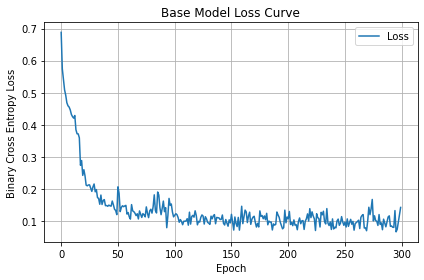

In [85]:

# model = ResNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_hidden=num_hidden, skip_param=1, activation=activation)

# Train both models
model_base, acc_base, losses_base = train_until_threshold(ResNet,
    train_loader, test_loader,
    load_file = load_file, max_retries=5, threshold=0.95,
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_hidden=num_hidden, skip_param=0, activation=activation
)

plot_loss_curve(losses_base, title=f"Base Model Loss Curve", filename = 'ff6hidden')

In [86]:
model_base.parameters

<bound method Module.parameters of ResNet(
  (input_fc): Linear(in_features=2, out_features=2, bias=True)
  (activation): Tanh()
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): Tanh()
    )
    (1): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): Tanh()
    )
    (2): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): Tanh()
    )
    (3): ResidualBlock(
      (fc): Linear(in_features=2, out_features=2, bias=True)
      (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): Tanh()
    )
    (4)

Plot saved to ff6hiddencirc6.png
Plot saved to ff6hiddencirc_contour6.png


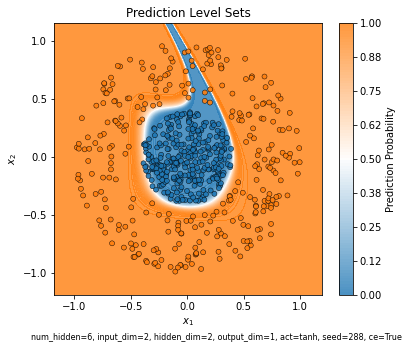

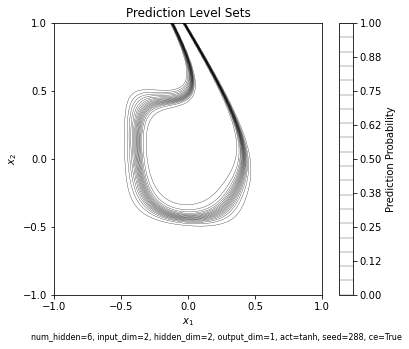

In [87]:
import importlib
import plots.plots 
from plots.plots import plot_decision_boundary, plot_level_sets
importlib.reload(plots.plots) # Reload the module

X_test, y_test = next(iter(test_loader))
plot_decision_boundary(model_base, X_test, y_test, show=True, file_name= 'ff6hiddencirc' + str(num_hidden), footnote = footnote, amount_levels= 100)
plot_level_sets(model_base, show=True, file_name= 'ff6hiddencirc_contour' + str(num_hidden), footnote = footnote, amount_levels= 20)



# Model with width 3

In [ ]:
X_test, y_test = next(iter(test_loader))
# num_epochs = 300

skip_values = np.linspace(0, 1, 9)  # e.g., [0.0, 0.125, ..., 1.0]
# skip_values = [0, 0, 0 , 0 , 0]  # e.g., [0.0, 0.125, ..., 1.0]
n_cols = 3
n_rows = int(np.ceil(len(skip_values) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), facecolor='white')
# num_epochs = 10
for idx, skip in enumerate(skip_values):
    print(f"Training model with skip_param = {skip:.2f}")
    
    # seed = 163
    print(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    model = ResNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
                   num_hidden=num_hidden, skip_param=skip, activation=activation)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCEWithLogitsLoss() if cross_entropy else nn.MSELoss()

    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    ax = axes.flatten()[idx]
    plot_decision_boundary(model, X_test, y_test, title=f"Skip: {skip:.2f}", ax=ax, show=False, colorbar=False)

# Hide unused subplots
for i in range(len(skip_values), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

fig.suptitle(f"ResNets with amount layers = {num_hidden + 2} and different weights of shortcut", fontsize=16)

# 💡 Leave room at top for the title
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.tight_layout()
plt.show()

# Singular value computations and plotting
We want to determine singular points in the compact space

In [ ]:
# Define a grid over the input space.
grid_size = 200 # Adjust as needed.

def psi_manual(x, func):
    """
    x: a tensor of shape (2,) representing a point in R^2.
    model: a function mapping R^2 to R^output_dim.
    
    Returns:
      The smallest singular value of the Jacobian of model at x.
    """
    # Ensure x is a leaf variable with gradient tracking enabled.
    x = x.clone().detach().requires_grad_(True)
    
    # Define a lambda function to ensure accurate input-output mapping
    # func = lambda inp: model(inp, output_layer = False)
    
    # Compute the Jacobian using torch.autograd.functional.jacobian (compatible with Python 3.8)
    jacobian = torch.autograd.functional.jacobian(func, x, create_graph=True)
    
    # Compute singular values using svdvals (available in PyTorch 1.8, compatible with Python 3.8)
    singular_values = torch.svd(jacobian, compute_uv=False)[1] #svd interprets here the jacobian as a SQUARE matrix of the largest dimension, hence it 
    
   
    return singular_values.detach().numpy()



x_range = np.linspace(-1, 1, grid_size)
y_range = np.linspace(-1, 1, grid_size)
psi_values = np.zeros((grid_size, grid_size, 2))

# Put the model in evaluation mode.
model.eval()
func = lambda inp: model(inp, output_layer = False)

# Evaluate psi(x) over the grid.
for i, xv in enumerate(x_range):
    for j, yv in enumerate(y_range):
        # Create a 2D point as a torch tensor.
        x_point = torch.tensor([xv, yv], dtype=torch.float32)
        psi_values[j, i,:] = psi_manual(x_point, func)

In [ ]:

# Plot the contour corresponding to psi ~ 0.
plt.figure(figsize=(8, 6))
# Here we plot the contour at a small level, e.g., 0.01.
# CS = plt.contour(x_range, y_range, psi_values, levels=[0,0.05,0.1,0.2,0.3], colors='red')

# Define the number of levels for the contour plot
vmin1, vmax1 = psi_values[:, :, 1].min(), psi_values[:, :, 1].max()
num_levels = 100
levels1 = np.linspace(0, vmax1, num_levels)
# Create the contour plot using the 'binary' colormap
CS = plt.contourf(x_range, y_range, psi_values[:,:,1], levels=levels1, cmap = 'viridis')
cbar = plt.colorbar(CS)
plt.title('smallest singular value of Jacobian \nno output layer')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Plot the contour corresponding to psi ~ 0.
plt.figure(figsize=(8, 6))
# Here we plot the contour at a small level, e.g., 0.01.
# CS = plt.contour(x_range, y_range, psi_values, levels=[0,0.05,0.1,0.2,0.3], colors='red')

# Define the number of levels for the contour plot

vmin0, vmax0 = psi_values[:, :, 0].min(), psi_values[:, :, 0].max()
num_levels = 100
levels0 = np.linspace(0, vmax0, num_levels)
# Create the contour plot using the 'binary' colormap
CS = plt.contourf(x_range, y_range, psi_values[:,:,0], levels=levels0, cmap = 'viridis')
cbar = plt.colorbar(CS)
plt.title('largest singular value of Jacobian \nno output layer')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Put the model in evaluation mode.
model.eval()

# Prepare figure and axes
fig, axes = plt.subplots(2, num_hidden + 2, figsize=(5 * (num_hidden + 2), 10))  # Adjust figsize if needed

for layer in range(num_hidden + 2):
    func = lambda inp: model.sub_model(inp, from_layer=0, to_layer = layer)

    # Evaluate psi(x) over the grid.
    for i, xv in enumerate(x_range):
        for j, yv in enumerate(y_range):
            x_point = torch.tensor([xv, yv], dtype=torch.float32)
            psi_values[j, i, :] = psi_manual(x_point, func)

    # Determine contour levels
    vmin1, vmax1 = psi_values[:, :, 1].min(), psi_values[:, :, 1].max()
    num_levels_contour = 200
    levels1 = np.linspace(0, vmax1, num_levels_contour)

    # Plot smallest singular value (index 1) - first row
    ax = axes[0, layer] if num_hidden > 1 else axes[0]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 1], levels=levels1, cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Min SV\n layer_in = 0, layer_out = {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')
    
    # Determine contour levels
    vmin0, vmax0 = psi_values[:, :, 0].min(), psi_values[:, :, 0].max()
    num_levels_contour = 200
    levels0 = np.linspace(0, vmax0, num_levels_contour)
    

    # Plot largest singular value (index 0) - second row
    ax = axes[1, layer] if num_hidden > 1 else axes[1]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 0], levels=levels0, cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Max SV\n layer_in = 0, layer_out = {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Put the model in evaluation mode.
model.eval()

# Prepare figure and axes
fig, axes = plt.subplots(2, num_hidden + 2, figsize=(5 * (num_hidden + 2), 10))  # Adjust figsize if needed

x_range = np.linspace(-1, 1, grid_size)
y_range = np.linspace(-1, 1, grid_size)

for layer in range(num_hidden + 2):
    func = lambda inp: model.sub_model(inp, from_layer = layer, to_layer=layer)

    # Evaluate psi(x) over the grid.
    for i, xv in enumerate(x_range):
        for j, yv in enumerate(y_range):
            x_point = torch.tensor([xv, yv], dtype=torch.float32)
            psi_values[j, i, :] = psi_manual(x_point, func)

    # Determine contour levels
    vmin1, vmax1 = psi_values[:, :, 1].min(), psi_values[:, :, 1].max()
    num_levels_contour = 200
    levels1 = np.linspace(0, vmax1, num_levels_contour)

    # Plot smallest singular value (index 1) - first row
    ax = axes[0, layer] if num_hidden > 1 else axes[0]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 1], 
                     levels=levels1,
                     cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Min SV\n layer {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')
    

    # Determine contour levels
    vmin0, vmax0 = psi_values[:, :, 0].min(), psi_values[:, :, 0].max()
    num_levels_contour = 200
    levels0 = np.linspace(0, vmax0, num_levels_contour)

    # Plot largest singular value (index 0) - second row
    ax = axes[1, layer] if num_hidden > 1 else axes[1]
    cs = ax.contourf(x_range, y_range, psi_values[:, :, 0],
                     levels=levels0, 
                     cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(f'Max SV\n layer {layer}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


In [ ]:
# Prepare figure and axes
fig, axes = plt.subplots(1, 2, figsize=(10 , 5))  # Adjust figsize if needed



class TestFunc(nn.Module):
    def __init__(self):
        super(TestFunc, self).__init__()

    def forward(self, x):
        return torch.norm(x)**2
    
    
def psi_manual_test(x, func):
    """
    x: a tensor of shape (2,) representing a point in R^2.
    model: a function mapping R^2 to R^output_dim.
    
    Returns:
      The smallest singular value of the Jacobian of model at x.
    """
    # Ensure x is a leaf variable with gradient tracking enabled.
    x = x.clone().detach().requires_grad_(True)
    
    # Define a lambda function to ensure accurate input-output mapping
    # func = lambda inp: model(inp, output_layer = False)
    
    # Compute the Jacobian using torch.autograd.functional.jacobian (compatible with Python 3.8)
    jacobian = torch.autograd.functional.jacobian(func, x, create_graph=True).unsqueeze(0)
    print(f'{jacobian = }')
    
    # Compute singular values using svdvals (available in PyTorch 1.8, compatible with Python 3.8)
    singular_values = torch.svd(jacobian, compute_uv=False)[1]
    print(f'{singular_values = }')
    
   
    return singular_values.detach().numpy()

test_func = TestFunc()

# Evaluate psi(x) over the grid.
for i, xv in enumerate(x_range):
    for j, yv in enumerate(y_range):
        x_point = torch.tensor([xv, yv], dtype=torch.float32)
        psi_values[j, i, :] = psi_manual_test(x_point, test_func)
        

# Determine contour levels
vmin1, vmax1 = psi_values[:, :, 1].min(), psi_values[:, :, 1].max()
num_levels_contour = 200
levels1 = np.linspace(0, vmax1, num_levels_contour)

# Plot smallest singular value (index 1) - first row
ax = axes[0]
cs = ax.contourf(x_range, y_range, psi_values[:, :, 1], 
                    levels=levels1,
                    cmap='viridis')
fig.colorbar(cs, ax=ax)
ax.set_title(f'Min SV\n layer {layer}')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_aspect('equal')


# Determine contour levels
vmin0, vmax0 = psi_values[:, :, 0].min(), psi_values[:, :, 0].max()
num_levels_contour = 200
levels0 = np.linspace(0, vmax0, num_levels_contour)

# Plot largest singular value (index 0) - second row
ax = axes[1] 
cs = ax.contourf(x_range, y_range, psi_values[:, :, 0],
                    levels=levels0, 
                    cmap='viridis')
fig.colorbar(cs, ax=ax)
ax.set_title(f'Max SV\n layer {layer}')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()
